# My First LSTM

Author: Jakob Poffley  
Date: 25/01/2024

My first attempt at fitting an LSTM to labquake data from Marone experiment p4581 (same data used by SOTA Laurenti). Heavily inspired by Pritt and Camilla's code (and ChatGPT).

In [1]:
# Imports
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import torch.utils.data as data
import tqdm # progress bar


In [2]:
## Import local utils
MAIN_DICT = "/gws/nopw/j04/ai4er/users/pn341/earthquake-predictability"
sys.path.append(MAIN_DICT)

from utils.dataset import SlowEarthquakeDataset


In [3]:
# Check if CUDA (NVIDIA GPU acceleration) is available
if torch.cuda.is_available():
    dev, map_location = "cuda", None  # Use GPU
    print(
        f"Total GPUs available: {torch.cuda.device_count()}"
    )  # Display GPU count
    !nvidia-smi  # Display GPU details using nvidia-smi
else:
    dev, map_location = "cpu", "cpu"  # Use CPU
    print("No GPU available.")

# Set PyTorch device based on the chosen device (cuda or cpu)
device = torch.device(dev)

Total GPUs available: 4
Mon Feb  5 14:03:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  | 00000000:01:00.0 Off |                    0 |
| N/A   31C    P0              57W / 400W |   5252MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+-

In [4]:
# Set seed so code gives the same output each time
seed = 13

np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

## Load data

In [5]:
# Load the data
EXPERIMENT = "p4581"
dataset = SlowEarthquakeDataset(EXPERIMENT)
ds_exp = dataset[EXPERIMENT]
X, Y, t = ds_exp["X"], ds_exp["Y"], ds_exp["t"]

# Reshape into dataframe
ts_data = pd.DataFrame(
    np.hstack((X, Y, t.reshape(-1, 1))),
    columns=[ds_exp["hdrs"]["X"], *ds_exp["hdrs"]["Y"], ds_exp["hdrs"]["t"]],
)

# Select columns time and obs_shear_stress
ts_data = ts_data[["time", "obs_shear_stress"]]

ts_data


,time,obs_shear_stress
0,0.000,1.29911
1,0.001,1.29903
2,0.002,1.29853
3,0.003,1.29871
4,0.004,1.29854
...,...,...
200005,200.006,1.37059
200006,200.007,1.37069
200007,200.008,1.37066
200008,200.009,1.37040


Text(0.5, 1.0, 'Original Shear Stress Data, p4581')

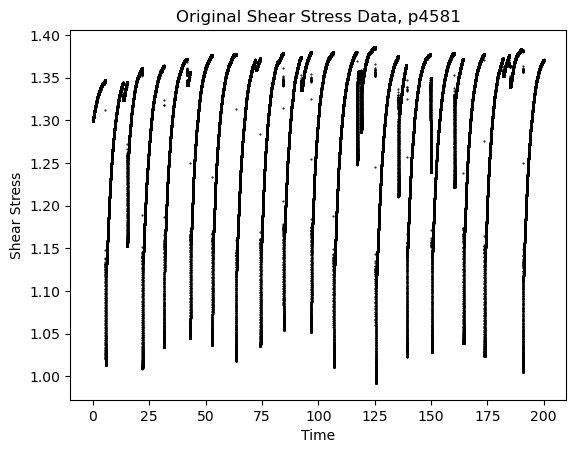

In [6]:
# Visualise the data
plt.plot("time", "obs_shear_stress", "k.", markersize =1, data=ts_data)
plt.xlabel("Time")
plt.ylabel("Shear Stress")
plt.title("Original Shear Stress Data, p4581")


Text(0.5, 1.0, 'Original Shear Stress Data, p4581 (x zoomed)')

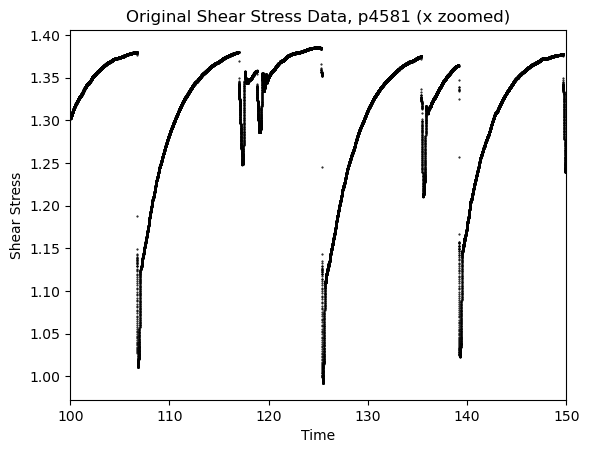

In [14]:
## Zoom into a shorter section
plt.plot("time", "obs_shear_stress", "k.", markersize =1, data=ts_data)
plt.xlim(100, 150)
plt.xlabel("Time")
plt.ylabel("Shear Stress")
plt.title("Original Shear Stress Data, p4581 (x zoomed)")


## Data Downsampling

In [7]:
# Set downsampling factor
DS_FACTOR = 10e2

# Downsample taking mean for each window
ts_ds_data = ts_data.rolling(window=int(DS_FACTOR), step=int(DS_FACTOR)).mean().dropna()
# Reset indices and drop rows with missing data
ts_ds_data = ts_ds_data.reset_index(drop=True)
ts_ds_data = ts_ds_data.dropna()

ts_ds_data

,time,obs_shear_stress
0,0.500503,1.306805
1,1.500508,1.320308
2,2.500513,1.330455
3,3.500518,1.337728
4,4.500523,1.342874
...,...,...
195,195.501477,1.321985
196,196.501482,1.341269
197,197.501487,1.353808
198,198.501492,1.362479


Text(0.5, 1.0, 'Downsampled Shear Stress Data, p4581')

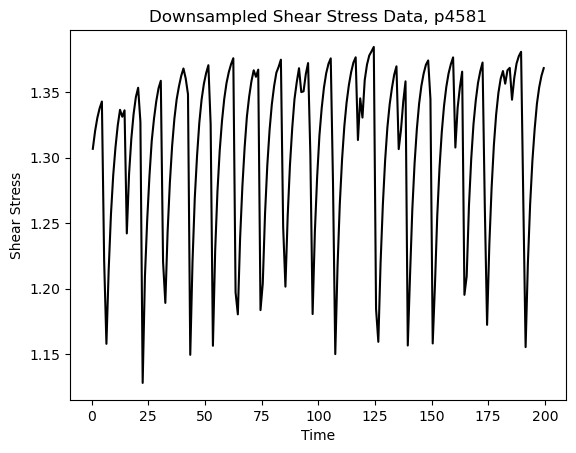

In [16]:
# Visualise downsampled data
plt.plot("time", "obs_shear_stress", "k-", markersize =1, data=ts_ds_data)
plt.xlabel("Time")
plt.ylabel("Shear Stress")
plt.title("Downsampled Shear Stress Data, p4581")

## Modelling

### Create sequences of X and y's

In [8]:
# Function to create sequences based on LOOKBACK and FORECAST
def create_sequences(data, LOOKBACK, FORECAST):
    xs, ys = [], []
    for i in range(len(data) - LOOKBACK - FORECAST + 1):
        x = data[i : (i + LOOKBACK)]
        y = data[(i + LOOKBACK) : (i + LOOKBACK + FORECAST)]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Define LOOKBACK and FORECAST
LOOKBACK = 10
FORECAST = 1

# Generate X and y sequences
X, y = create_sequences(ts_ds_data["obs_shear_stress"].values, LOOKBACK, FORECAST)


### Feature scaling and test/train split

In [9]:
# Set scaling function
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Define split proportions
train_size = int(len(y) * 0.8)

# Perform train-test split and apply scaling
# note: the test set is transformed using the parameters fit on training data
X_train = scaler_X.fit_transform(X[:train_size])
X_test = scaler_X.transform(X[train_size:]) 
y_train = scaler_y.fit_transform(y[:train_size])
y_test = scaler_y.transform(y[train_size:])

# Convert to tensors and send to the device where model training will be done
X_train = torch.from_numpy(np.array(X_train, dtype=np.float32)).to(device)
y_train = torch.from_numpy(np.array(y_train, dtype=np.float32)).to(device)
X_test = torch.from_numpy(np.array(X_test, dtype=np.float32)).to(device)
y_test = torch.from_numpy(np.array(y_test, dtype=np.float32)).to(device)



In [19]:
# Check tensor dimensions
print(f"Training data shapes: {X_train.shape}, {y_train.shape}")
print(f"Testing data shapes: {X_test.shape}, {y_test.shape}")


Training data shapes: torch.Size([152, 10]), torch.Size([152, 1])
Testing data shapes: torch.Size([38, 10]), torch.Size([38, 1])


In [10]:
# Dataloader used to shuffle sequences - is this necessary?
loader = data.DataLoader(
    data.TensorDataset(X_train, y_train), shuffle=True, batch_size=32
)

### Define model

In [11]:
# Define the LSTM model - I don't fully understand what is going on here yet
class LSTM(nn.Module):
    def __init__(self, n_variates, hidden_size, num_layers, output_steps):
        super(LSTM, self).__init__()

        # LSTM layer
        self.lstm = nn.LSTM(n_variates, hidden_size, num_layers, batch_first=True)

        # Define the output layer
        self.fc = nn.Linear(hidden_size, output_steps)

        # not sure if the following are needed?
        # self.hidden_size = hidden_size
        # self.num_layers = num_layers
        # # self.fc1 = nn.Linear(num_layers * hidden_size, 128)
        # # self.fc2 = nn.Linear(128, output_steps)
        # self.relu = nn.ReLU()

    def forward(self, x):
        # Initialise hidden state and cell state - what does this mean?
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(device)
        
        # Forward pass through LSTM layer
        lstm_out, _ = self.lstm(x, (h0, c0))

        # Take output from last time step from the LSTM
        lstm_out = lstm_out[:, -1, :]

        # Forward pass through output layer
        out = self.fc(lstm_out)
        
        return out

# Choose hyperparameters
n_variates = 1 
hidden_size = 50
num_layers = 1
output_steps = FORECAST
learning_rate = 0.001
num_epochs = 200


### Train Model

In [12]:
# Initialize the model, loss function, and optimizer
model = LSTM(n_variates, hidden_size, num_layers, output_steps).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [23]:
# Check model architecture
print(model)

LSTM(
  (lstm): LSTM(1, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)


In [13]:
# Setup progress bar
pbar = tqdm.tqdm(range(num_epochs))

# Lists to store RMSE values for plotting
train_rmse_list = []
test_rmse_list = []

# Training the model - I don't understand this code yet
for epoch in pbar:
    model.train()

    # Iterate through batches in DataLoader
    for X_batch, y_batch in loader:
        outputs = model(X_batch.unsqueeze(-1))
        loss = criterion(outputs, y_batch)

        # Backward pass and optimisation step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    
    # Evaluate model without backpropogation (not considering gradient)
    with torch.no_grad():
        # Evaluating on training data
        y_train_pred = model(X_train.unsqueeze(-1))
        y_train_pred = torch.Tensor(scaler_y.inverse_transform(y_train_pred.cpu())).to(device)
        
        train_rmse = torch.sqrt(criterion(y_train_pred, y_train))
        train_rmse_list.append(train_rmse.item())

        # Evaluating on test data
        y_test_pred = model(X_test.unsqueeze(-1))
        y_test_pred = torch.Tensor(scaler_y.inverse_transform(y_test_pred.cpu())).to(device)
        
        test_rmse = torch.sqrt(criterion(y_test_pred, y_test))
        test_rmse_list.append(test_rmse.item())



    # Update progress bar
    pbar.set_description(
        f"Epoch [{epoch+1}/{num_epochs}], Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}"
    )

Epoch [200/200], Train RMSE: 0.6429, Test RMSE: 0.6225: 100%|██████████| 200/200 [00:02<00:00, 83.98it/s]


## Model Evaluation

In [14]:
# Final train and test RMSE
print(f"Final train RMSE: {train_rmse_list[num_epochs-1]:.4f}, Final test RMSE: {test_rmse_list[num_epochs-1]:.4f}")

Final train RMSE: 0.6429, Final test RMSE: 0.6225


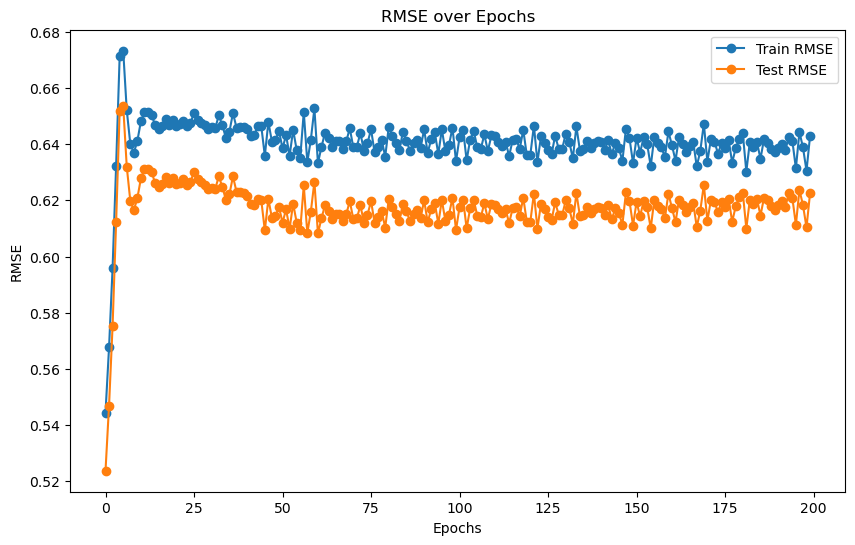

In [15]:
# Plot RMSE over epochs - This doesn't look right!!
plt.figure(figsize=(10, 6))
plt.plot(range(0, num_epochs), train_rmse_list, label="Train RMSE", marker="o")
plt.plot(range(0, num_epochs), test_rmse_list, label="Test RMSE", marker="o")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.title("RMSE over Epochs")
plt.legend()
plt.show()

In [23]:
# Plot of forecasts vs true values
    